In [12]:
import warnings;
warnings.filterwarnings('ignore');

# RDS Decoding

### Tuning to an FM channel


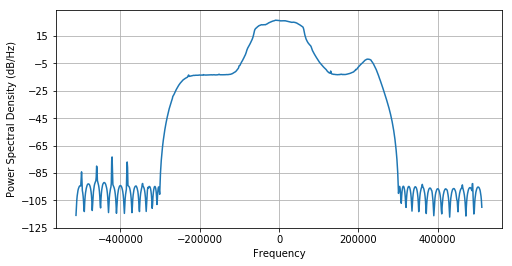

In [13]:
import numpy as np
import scipy.signal as signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from matplotlib import gridspec

# FM station recorded using SDRsharp
fs, data = wavfile.read('FM_105000000Hz_IQ.wav', mmap=True)
wo = 2*np.pi*100000/fs

# Complex IQ representation of the data
IQ = data[:,0] + 1j*data[:,1]

# low pass filter for the FM channel bandwidth
channelFilt = signal.remez(50, [0, 200000, 300000, fs/2], [1,0], fs=fs)

# Demodulate the channel to baseband, then filter 
IQ = IQ*np.exp(-1j*wo*np.arange(IQ.shape[0]))
IQ = signal.convolve(IQ, channelFilt, mode='valid')

# Plot the spectrum of the FM channel
plt.figure(figsize= (8,4))
plt.psd(IQ, Fs=fs, NFFT = 1024)
plt.show()


### Demodulating the FM multiplex signal

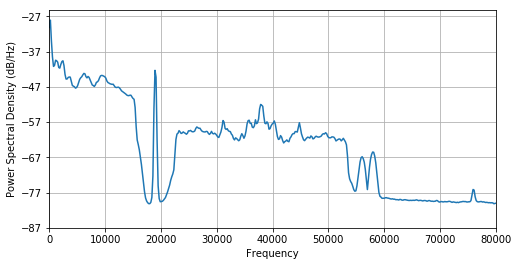

In [14]:
# Decimate to reduce the sample rate from 1.024 Msps to 192 ksps
fsM = 192000
IQ = signal.resample_poly(IQ, 3, 16)

# FM demodulation 
MPX_FM = np.angle([x[0]*np.conj(x[1]) for x in zip(IQ[1:], IQ[:-1])])

# Plot the multiplex spectrum of the FM channel
plt.figure(figsize= (8,4))
plt.psd(MPX_FM, Fs=fsM, NFFT=1024)
plt.xlim([0, 80000])
plt.show()

In [15]:
# filter out the audio signals
wo = 2*np.pi*57000/fsM  # RDS subcarrier frequency
RDSFilt = signal.remez(192,[0, 2000, 4000, fsM/2],[1,0], fs=fsM) 
RDSFilt57 = RDSFilt*np.cos(wo*np.arange(RDSFilt.shape[0]))
RDS_57 = 10*signal.convolve(MPX_FM, RDSFilt57, mode='same')


### Obtaining the 57kHz RDS subcarrier

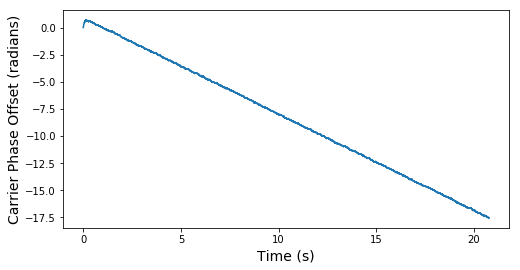

In [16]:
# This is a Costas loop implementation based on the Matlab code provided in 
# Telecommunication Breakdown, by C. Richard Johnson Jr. and William A. Sethares.

def phase_recovery(sig_in, flen, loop_gain, loop_bw, w, fs):
    '''
    INPUTS:
        sig_in: supressed-carrier signal to recover the phase from
        flen: length of loop filter
        loop_gain: loop gain for Costas loop
        loop_bw: bandwidth of loop filter
        w: expected carrier frequency in rad/s
        fs: sample rate of the input signal
    OUTPUT:
        theta: estimate of the carrier phase offset'''
    
    nn = np.arange(sig_in.shape[0])  
    zs = np.zeros((flen,))       # preallocate array for use in loop
    zc = np.zeros((flen,))
    loop_filt = signal.remez(flen, [0, loop_bw, 2*loop_bw, fs/2], [1, 0], fs = fs)
    theta = np.zeros(nn.shape) # array for storing carrier phase offset
    
    for k in range(len(nn)-1):
        zs = np.append(zs[1:], 2*sig_in[k]*np.sin(w*nn[k] + theta[k]))
        zc = np.append(zc[1:], 2*sig_in[k]*np.cos(w*nn[k] + theta[k]))
        lpfs = np.dot(loop_filt, zs)
        lpfc = np.dot(loop_filt, zc)
        theta[k+1] = theta[k] - loop_gain*lpfs*lpfc
    
    return theta

theta0 = phase_recovery(RDS_57, 20, 0.01, 2000, wo, fsM)

# plot the obtained carrier phase
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(theta0))/fsM, theta0)
plt.ylabel('Carrier Phase Offset (radians)', fontsize=14)
plt.xlabel('Time (s)', fontsize=14)
plt.show()




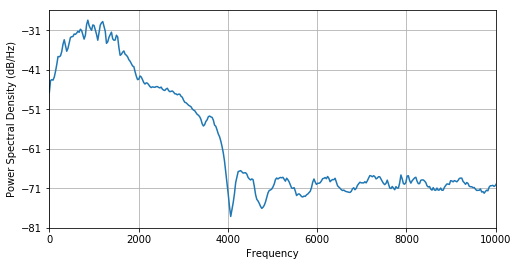

In [17]:
recovered_carrier57 = np.cos(wo*np.arange(MPX_FM.shape[0]) + theta0)
uncorrected_carrier57 = np.cos(wo*np.arange(MPX_FM.shape[0]))
RDS = RDS_57*recovered_carrier57
RDS_uncorr0 = RDS_57*uncorrected_carrier57

# Reduce the sample rate to 57ksps by resampling.
RDS = signal.resample_poly(RDS, 57, 192)*10
RDS_uncorr0 = signal.resample_poly(RDS_uncorr0, 57, 192)*10
fsR = 57000 # new sample frequency

# normalize
RDS = RDS/np.sqrt(np.mean(np.abs(RDS)**2))
RDS_uncorr0 = RDS_uncorr0/np.sqrt(np.mean(np.abs(RDS_uncorr0)**2))

# # Plot the baseband RDS spectrum
plt.figure(figsize= (8,4))
plt.psd(RDS, Fs=fsR, NFFT=2048)
plt.xlim([0,10000])
plt.show()


### Demodulating the RDS BPSK signal

In [18]:
# Using the recovered 57kHz carrier phase to create a frequency synchronized 1187.5Hz symbol carrier
symcarrier = np.cos((wo*np.arange(MPX_FM.shape[0]) + theta0)/48)
recovered_carrier1187 = signal.resample_poly(symcarrier, 57, 192)

basefilt0 = signal.remez(96, [0, 400, 1500, fsR/2], [1, 0], fs = fsR)

# demodulate the BPSK signal
RDS_demod = RDS*recovered_carrier1187
RDS_demod = signal.lfilter(basefilt0, 1.0, RDS_demod)

nn = np.arange(RDS.shape[0]) 
wc = 2*np.pi*1187.5/fsR   # expected carrier frequency

# Also demodulate without phase correction
RDS_demod_uncorr01 = RDS_uncorr0*np.cos(wc*nn)
RDS_demod_uncorr01 = signal.lfilter(basefilt0, 1.0, RDS_demod_uncorr01)

### Symbol Timing Recovery

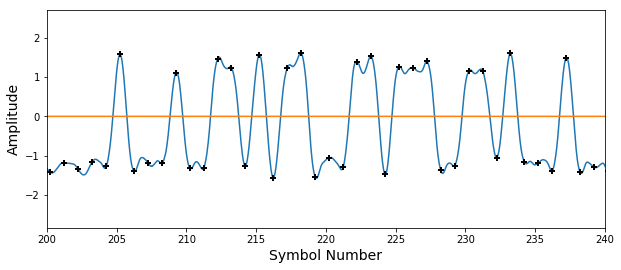

In [19]:
# number of symbols to include in each timing recovery block
block_N = 26

# preallocate space for the samples
RDS_sampled = np.zeros((int(RDS_demod.shape[0]/48),), dtype=complex)
all_sample_locations = np.array([])

# loop through the signal
for ii in range(int(RDS_demod.shape[0]/(block_N*48) - 1)):
    # get a chunk of length 48*block_N
    chunk = RDS_demod[ii*(block_N*48):(ii+1)*(block_N*48)]
    
    # create a 'comb' to pick out sample values
    sample_comb = np.zeros(chunk.shape)
    sample_comb[0:-1:48] = 1
    
    # determine the total signal power for each sampling offset
    signal_power = np.zeros((48,))
    for kk in range(48):
        xx = np.roll(sample_comb, kk).astype(bool)
        sa = np.real(chunk[xx])
        power = np.sum(sa**2)
        signal_power[kk] = power
    
    # fild the offset which maximizes the output power
    optimal_offset = np.argmax(signal_power)
    optimal_samples = np.roll(sample_comb, optimal_offset).astype(bool)
    
    # save the optimal samples and their indices
    RDS_sampled[ii*block_N:(ii+1)*block_N] = chunk[optimal_samples]
    all_sample_locations = np.concatenate((all_sample_locations, optimal_samples))

    
# plot the demodulated signal and its samples
fig = plt.figure(figsize=(10, 4))
plt.plot(nn/48, np.real(RDS_demod)*2)
plt.plot(nn/48, np.zeros(nn.shape))

ns = np.arange(all_sample_locations.shape[0])
ns = ns[all_sample_locations.astype(bool)]
plt.plot(ns/48 , 2*RDS_sampled[0:ns.shape[0]], 'k+', mew = 2)
plt.xlim([200, 240])

plt.xlabel('Symbol Number', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)

plt.show()

### Comparing the output with and without carrier phase recovery and symbol timing recovery

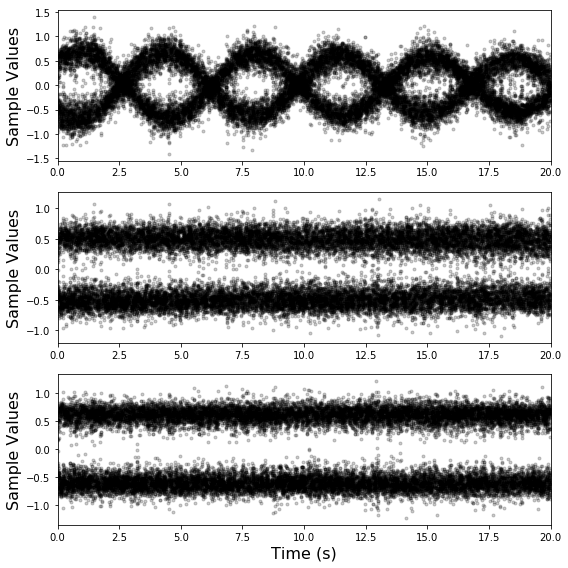

In [20]:
'''Plot the real part of the constellation diagram over time in order to compare 
the output with and without carrier phase and symbol timing recovery '''

RDS_sa_nosync = RDS_demod[::48]
RDS_sa_nosync_uncorr01 = RDS_demod_uncorr01[::48]

ns = np.arange(RDS_sampled.shape[0])
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 1)

plt.subplot(gs[0])
plt.plot(ns.astype(float)/1187.5, np.real(RDS_sa_nosync_uncorr01[:-1]), 'k.', alpha = 0.2)
plt.ylabel('Sample Values', fontsize=16)
plt.xlim([0,20])

plt.subplot(gs[1])
plt.plot(ns.astype(float)/1187.5, RDS_sa_nosync[:-1], 'k.', alpha = 0.2)
plt.ylabel('Sample Values', fontsize=16)
plt.xlim([0,20])

plt.subplot(gs[2])
plt.plot(ns.astype(float)/1187.5, RDS_sampled, 'k.', alpha = 0.2)
plt.ylabel('Sample Values', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.xlim([0,20])

plt.tight_layout()
plt.show()

(Top) No carrier phase synchronization or timing recovery. (Middle) With carrier phase synchronization but no symbol timing recovery. (Bottom) With carrier phase synchronization and symbol timing recovery.

### Decoding the received bitstream

RDS data is transmitted in groups comprising 26 bits. The first 16 bits are data bits and the remaining 10 form a checkword.  

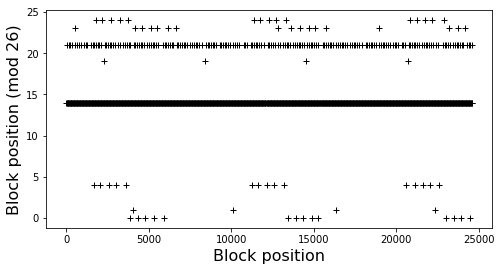

In [21]:
# Turn back now if using numpy arrays to do bitwise operations upsets you.

# Slicer: convert sample values to zeros and ones
RDS_bitstream = (np.sign(np.real(RDS_sampled))).astype(int)
RDS_bitstream[RDS_bitstream == -1] = 0

# differential decoding
RDS_bits = np.bitwise_xor(RDS_bitstream[1:], RDS_bitstream[:-1])

# syndromes corresponding to valid block types (see IEC 62106 p.xx)
checkw = np.array([[1,1,1,1,0,1,1,0,0,0],
                  [1,1,1,1,0,1,0,1,0,0],
                  [1,0,0,1,0,1,1,1,0,0],
                  [1,1,1,1,0,0,1,1,0,0],
                  [1,0,0,1,0,1,1,0,0,0]])

# names associated with each group type
mtypes = ['A', 'B', 'C', 'D','Cp'] 

# create the parity check matrix H as specified in IEC 62106 p.xx        
h1 = np.array([[1,0,1,1,0,1,1,1,0,0],
      [0,1,0,1,1,0,1,1,1,0],
      [0,0,1,0,1,1,0,1,1,1],
      [1,0,1,0,0,0,0,1,1,1],
      [1,1,1,0,0,1,1,1,1,1],
      [1,1,0,0,0,1,0,0,1,1],
      [1,1,0,1,0,1,0,1,0,1],
      [1,1,0,1,1,1,0,1,1,0],
      [0,1,1,0,1,1,1,0,1,1],
      [1,0,0,0,0,0,0,0,0,1],
      [1,1,1,1,0,1,1,1,0,0],
      [0,1,1,1,1,0,1,1,1,0],
      [0,0,1,1,1,1,0,1,1,1],
      [1,0,1,0,1,0,0,1,1,1],
      [1,1,1,0,0,0,1,1,1,1],
      [1,1,0,0,0,1,1,0,1,1]])
H = np.concatenate((np.eye(10), h1), axis=0)

block_offsets = []
HHDD = np.zeros((5,RDS_bits.shape[0]- 26 ))


# Find all blocks with valid checkwords
for j in range(RDS_bits.shape[0]- 26):
    y = RDS_bits[j:j+26] 
    cw = np.mod(y.T@H, 2*np.ones((10,)))
    
    # Check if the computed checkword offset corresponds to one of the valid block types.
    for k in range(5):
        hammingdist = np.count_nonzero(cw-checkw[k,:])
        if np.count_nonzero(hammingdist) == 0:
            block_offsets.append(j)

hitindex = [h % 26 for h in block_offsets]

# plot the index (mod 26) where each successful block is detected. 
# RDS transmits blocks continually with no gaps, so ideally this should be a horizontal line.

plt.figure(figsize=(8,4))
plt.plot(block_offsets, hitindex, 'k+')
plt.ylabel('Block position (mod 26)', fontsize=16)
plt.xlabel('Block position', fontsize=16)
plt.show()

In [22]:
np.savetxt('RDS_BITSTREAM.txt', RDS_bits, fmt='%d', delimiter='', newline='')